In [224]:
import pandas as pd
from skimpy import skim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from neuralforecast import NeuralForecast
from mlforecast import MLForecast
from statsforecast.models import Naive, SeasonalNaive, SimpleExponentialSmoothing, RandomWalkWithDrift
from statsforecast import StatsForecast
from neuralforecast.models import LSTM, GRU, NBEATS, TFT, MLP
import time

# --------------------------------------------------------------
# Day 16: Model training
# --------------------------------------------------------------

In [2]:
def plot_ts(df):
    code = df['postcode'].values[0]
    property_type = df['propertyType'].values[0]
    plt.plot(df['full_date'], df['price/bedroom'])
    plt.title(f'Price/Bedroom vs. Date Sold for Post Code {code} and Housing Type {property_type}')
    plt.xlabel('Date Sold')
    plt.ylabel('Price/Bedroom')

In [225]:
def predict_and_visualize_forecast(model, ts, horizon):
    model_str = list(model.models.keys())[0]
    preds = model.predict(horizon)[model_str]
    code = ts['postcode'].values[0]
    prop = ts['propertyType'].values[0]
    plt.plot(range(ts['full_date'].shape[0]), ts['price/bedroom'])
    plt.plot(range(ts['full_date'].shape[0], ts['full_date'].shape[0] + horizon), preds)
    plt.xlabel('index')
    plt.ylabel('price/bedroom')
    plt.title(f'Forecast for Price/Bedroom for Postcode {code} and Housing Type {prop}')
    plt.legend(['history', 'forecast'])
    plt.show()

In [89]:
def prepare_and_clean_frames(master_df, post_code, housing_type):

    master_df['datesold'] = master_df['datesold'].apply(lambda x: pd.to_datetime(x))

    master_df['datesold_year'] = master_df['datesold'].apply(lambda x: x.year)
    master_df['datesold_month'] = master_df['datesold'].apply(lambda x: x.month)
    master_df['datesold_day'] = master_df['datesold'].apply(lambda x: x.day)
    
    unit_code = master_df[(master_df['postcode'] == post_code) & (master_df['propertyType'] == housing_type)].sort_values('datesold')

    unit_code_final = unit_code.groupby(['datesold_year', 'datesold_month']).agg({
    'postcode':pd.Series.mode, 'price':'sum', 'propertyType':pd.Series.mode, 'bedrooms':'sum', 
    }).reset_index()

    unit_code_final['full_date'] = pd.to_datetime(
        unit_code_final['datesold_year'].astype(str) + '-' + unit_code_final['datesold_month'].astype(str) + '-01'
        )
    unit_code_final['price/bedroom'] = unit_code_final['price']/unit_code_final['bedrooms']

    unit_code_final = unit_code_final.drop(['datesold_year', 'datesold_month','price', 'bedrooms'], axis=1)

    date_range = pd.date_range(start=unit_code_final['full_date'].min(), end=unit_code_final['full_date'].max(), freq='MS')
    missing_dates = date_range.difference(unit_code_final['full_date'])

    missing_df = pd.DataFrame({
        'postcode':post_code,
        'propertyType':housing_type,
        'full_date': missing_dates,
        'price/bedroom':np.nan
    })

    full_data = pd.concat([missing_df,unit_code_final]).sort_values('full_date')

    full_data['price/bedroom'] = full_data['price/bedroom'].ffill()
    
    if np.inf in full_data['price/bedroom'].values:
        with_inf = full_data[full_data['price/bedroom'] == np.inf]
        without_inf = full_data[full_data['price/bedroom'] != np.inf]
        with_inf['price/bedroom'] = np.mean(without_inf['price/bedroom'])
        full_data = pd.concat([with_inf, without_inf])

    return full_data


In [117]:
def run_BaselineForecast(df):

    df_NIXTLA = pd.DataFrame({
        'unique_id':0,
        'ds': df['full_date'],
        'y': df['price/bedroom']
    })
    
    models = [Naive(), RandomWalkWithDrift(), SimpleExponentialSmoothing(alpha=.8)]
    model_dict = {
        'Naive': Naive(),
        'RWD': RandomWalkWithDrift(),
        'SES': SimpleExponentialSmoothing(alpha=.8),
    }

    model = StatsForecast(
        df=df_NIXTLA,
        models=models,
        freq='MS',
        n_jobs=-1
    )

    df_cv = model.cross_validation(
        df=df_NIXTLA,
        step_size=1,
        h=8,
        n_windows=3
    )

    final_models = []
    max_error = 10e10
    for col in df_cv.columns[3:]:
        try:
            error = mean_absolute_error(df_cv['y'], df_cv[col])
        except:
            error = 10e10
        if error < max_error:
            max_error = error
            best_model = col
    
    model_func = model_dict[best_model]
    errors_on_best = df_cv[['ds', 'y', best_model]]
    trained_model = model.fit(df_NIXTLA)

    final_model = model_func
    kwargs = {
        'ts':df_NIXTLA,
        'model':final_model,
        'model_sig':best_model,
        'cv_df':df_cv,
        'cv_selected':errors_on_best,
        'error':max_error
    }
    
    return kwargs



In [114]:
def run_MLForecast(df):

    df_NIXTLA = pd.DataFrame({
        'unique_id':0,
        'ds': df['full_date'],
        'y': df['price/bedroom']
    })
    
    models = [XGBRegressor(), RandomForestRegressor(), LinearRegression()]
    model_dict = {
        'XGBRegressor': XGBRegressor(),
        'RandomForestRegressor': RandomForestRegressor(),
        'LinearRegression': LinearRegression(),
    }

    model = MLForecast(
        models=models,
        lags = [1,2,3,4,5,6],
        freq='MS'
    )

    df_cv = model.cross_validation(
        df=df_NIXTLA,
        h=3,
        n_windows=3
    )

    final_models = []
    max_error = 10e10
    for col in df_cv.columns[4:]:
        try:
            error = mean_absolute_error(df_cv['y'], df_cv[col])
        except:
            error = 10e10
        if error < max_error:
            max_error = error
            best_model = col
    
    model_func = model_dict[best_model]
    errors_on_best = df_cv[['ds', 'y', best_model]]
    trained_model = model.fit(df_NIXTLA)

    final_model = MLForecast(
        models = model_func,
        lags = [1,2,3,4,5,6],
        freq = 'MS'
    )

    final_model.fit(df_NIXTLA)

    kwargs = {
        'ts':df_NIXTLA,
        'model':final_model,
        'model_sig':best_model,
        'cv_df':df_cv,
        'cv_selected':errors_on_best,
        'error':max_error
    }
    
    return kwargs



In [143]:
# driver code

df = pd.read_csv('raw_sales.csv')
all_postcodes = df['postcode'].unique()
housing_type_1 = 'unit'
housing_type_2 = 'house'

ts_sets = {}

for code in all_postcodes:
    try:
        code_house = prepare_and_clean_frames(df, code, 'house')
        code_unit = prepare_and_clean_frames(df, code, 'unit')
        ts_sets[code] = [code_house, code_unit]
    except:
        ts_sets[code] = 'NOT ENOUGH DATA'

models_and_postcodes = {}
for postcode in all_postcodes:
    if ts_sets[postcode] != 'NOT ENOUGH DATA':
        models = []
        house_unit = [ts_sets[postcode][0], ts_sets[postcode][1]]
        for type in house_unit:
            naive = run_BaselineForecast(type)
            ml = run_MLForecast(type)
            if naive['error'] < ml['error']:
                models.append(naive['model'])
            else:
                models.append(ml['model'])
        models_and_postcodes[postcode] = models

/var/folders/k_/y5wzmsx1483f9z9t9tjtdj1m0000gn/T/ipykernel_50582/3415058516.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  with_inf['price/bedroom'] = np.mean(without_inf['price/bedroom'])


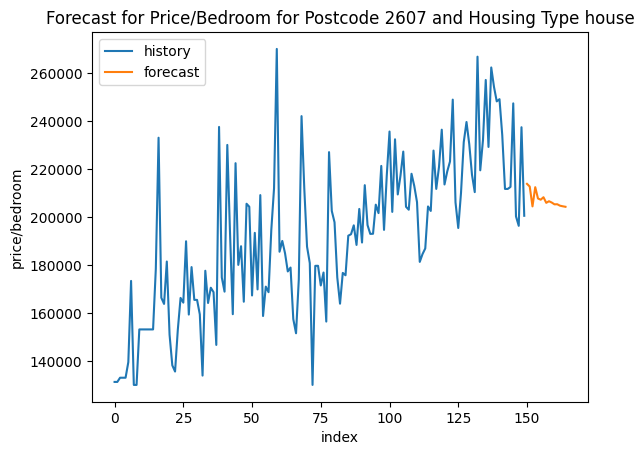

In [228]:
user_post = int(input('Enter a postcode (press q to quit): '))
user_type = input('Enter a housing type (unit or house): ')
user_hrzn = int(input('How many months into the future?: '))

if user_type == 'unit':
    idx = 1
else:
    idx = 0
predict_and_visualize_forecast(models_and_postcodes[user_post][idx], ts_sets[user_post][idx], user_hrzn)

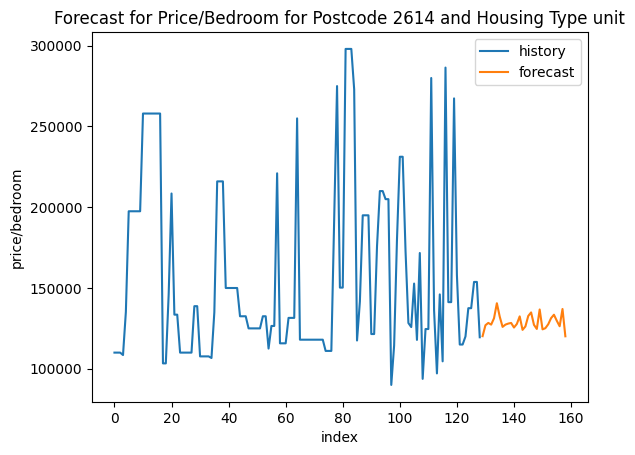

In [215]:
test_model = models_and_postcodes[2614][1]
test_ts = ts_sets[2614][1]
horizon = 30
predict_and_visualize_forecast(test_model, test_ts, horizon)

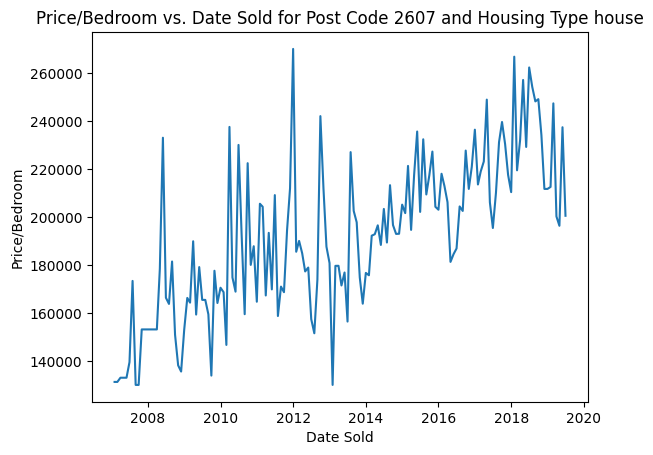

In [150]:
plot_ts(ts_sets[2607][0])

In [138]:
count = 0
for key in models_and_postcodes.keys():
    for model in models_and_postcodes[key]:
        if str(model).split('(')[0] == 'MLForecast':
            count+=1

In [140]:
33/50

0.66

In [90]:
what = prepare_and_clean_frames(df, 2605, 'unit')

/var/folders/k_/y5wzmsx1483f9z9t9tjtdj1m0000gn/T/ipykernel_50582/3415058516.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  with_inf['price/bedroom'] = np.mean(without_inf['price/bedroom'])
